In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle 
import re
import string
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN,Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential

In [2]:
#select GPU working %
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
#load Dataset

pd.set_option("display.max_colwidth",200)
data = pd.read_csv("Dataset.csv")
data.head()

review  \
0  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...   
1  A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...   
2  I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...   
3  Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...   
4  Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...   

  sentiment  
0  positive  
1  positive  
2  positive  
3  negative  
4  positive

In [6]:
data.describe()

review  \
count                                                                                                                                                                                                     50000   
unique                                                                                                                                                                                                    49582   
top     Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what w...   
freq                                                                                                                                                                                                          5   

       sentiment  
count      50000  
unique         2  
top     positive  
freq       25000

As we see unique column its look like there are duplicates value.

In [7]:
data.shape

(50000, 2)

In [8]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [11]:
#copy original data
message = data.copy()
message.head()

review  \
0  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...   
1  A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...   
2  I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...   
3  Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...   
4  Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...   

  sentiment  
0  positive  
1  positive  
2  positive  
3  negative  
4  positive

In [12]:
#view first column
message.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

**We see there are too many unnecessary things.**

In [13]:
#drop duplicates
messages = message.drop_duplicates()

In [14]:
messages.head()

review  \
0  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...   
1  A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...   
2  I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...   
3  Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...   
4  Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...   

  sentiment  
0  positive  
1  positive  
2  positive  
3  negative  
4  positive

In [15]:
from sklearn.utils import shuffle
messages = shuffle(messages)

In [16]:
messages.head(10)

review  \
37073  This series was a cut above the rest of the TV detective series of the day but somehow didn't find an audience.<br /><br />The idea of a blind detective may not be totally new but added so much to...   
18384  This is a genuinely horrible film. The plot (such as it is) is totally undecipherable. (I think it has something to do with blackmail, but I'm not entirely certain.)<br /><br />Half of the dialogu...   
20842  SLASHERS (2 outta 5 stars)<br /><br />Not really a very good movie... but I did like the idea behind it... and the the filmmakers did make it look pretty good considering the tiny budget they had ...   
40165  Although the likeliness of someone focusing on THIS comment among the other 80+ for this movie is low, I feel that I have to say something about this one. I am not the kind of movie-watcher who pa...   
19512  I could watch this movie ALL DAY! I LOVE it. Probably my all time favorite movies. But, by the way, "badger1970" there are a few parts with bad language, not TOO bad, but it's not exactly G rated....   
42258  <br /><br />my favorite science fiction, incredible ride through mistrust and the warping of reality. Probably the best performance I have ever seen Jude Law play. Incredibly original with interes...   
38880  I am an avid Julie Andrews fan and I just watched this for the first time on DVD -- the Director's Cut version. I was very surprised that it was rated G. How did they get bedroom scenes, a seducti...   
2715   This three stooges flick is at a tie with my other favorite flick "Disorder in the Court". This is an uproar of laughter for any Three Stooges fan to enjoy.<br /><br />The boys are janitors at a r...   
43172  Can a film be too faithful to the book upon which it is based? Judging from the time-spanning 2007 adaptation of Khaled Hosseini's huge 2003 seller, the answer is rather ironically "yes". Like man...   
45211  "Bride of Chucky" is one of the better horror movies to come out in the past ten years and could be one of the best horror films of the 90's.<br /><br />**SPOILERS**<br /><br />Chucky's girlfriend...   

      sentiment  
37073  positive  
18384  negative  
20842  negative  
40165  negative  
19512  positive  
42258  positive  
38880  positive  
2715   positive  
43172  positive  
45211  positive

In [17]:
len(messages)

49582

In [18]:
messages.reset_index(inplace = True)

In [19]:
messages.head()

index  \
0  37073   
1  18384   
2  20842   
3  40165   
4  19512   

                                                                                                                                                                                                    review  \
0  This series was a cut above the rest of the TV detective series of the day but somehow didn't find an audience.<br /><br />The idea of a blind detective may not be totally new but added so much to...   
1  This is a genuinely horrible film. The plot (such as it is) is totally undecipherable. (I think it has something to do with blackmail, but I'm not entirely certain.)<br /><br />Half of the dialogu...   
2  SLASHERS (2 outta 5 stars)<br /><br />Not really a very good movie... but I did like the idea behind it... and the the filmmakers did make it look pretty good considering the tiny budget they had ...   
3  Although the likeliness of someone focusing on THIS comment among the other 80+ for this movie is low, I feel that I have to say something about this one. I am not the kind of movie-watcher who pa...   
4  I could watch this movie ALL DAY! I LOVE it. Probably my all time favorite movies. But, by the way, "badger1970" there are a few parts with bad language, not TOO bad, but it's not exactly G rated....   

  sentiment  
0  positive  
1  negative  
2  negative  
3  negative  
4  positive

# Text preprocesing

In [20]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

review_lines = list()
lines = messages["review"].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    words = [wn.lemmatize(w) for w in words if w not in stopwords]
    review_lines.append(words)

In [21]:
len(review_lines)

49582

In [22]:
review_lines

[['series',
  'cut',
  'rest',
  'tv',
  'detective',
  'series',
  'day',
  'somehow',
  'nt',
  'find',
  'audience',
  'br',
  'br',
  'idea',
  'blind',
  'detective',
  'may',
  'totally',
  'new',
  'added',
  'much',
  'story',
  'could',
  'forget',
  'pax',
  'beautiful',
  'guide',
  'dog',
  'series',
  'br',
  'br',
  'whilst',
  'story',
  'may',
  'better',
  'average',
  'series',
  'setting',
  'new',
  'orleans',
  'acting',
  'music',
  'note',
  'comment',
  'music',
  'score',
  'comment',
  'remember',
  'clearly',
  'work',
  'make',
  'good',
  'television',
  'series',
  'even',
  'better',
  'br',
  'br',
  'well',
  'never',
  'know',
  'one',
  'day',
  'paramount',
  'might',
  'dig',
  'archive',
  'release',
  'dvd'],
 ['genuinely',
  'horrible',
  'film',
  'plot',
  'totally',
  'undecipherable',
  'think',
  'something',
  'blackmail',
  'entirely',
  'certain',
  'br',
  'br',
  'half',
  'dialogue',
  'consists',
  'useless',
  'cliche',
  'half',
  '

In [23]:

Y = messages["sentiment"]

In [24]:
#convert label in int.
Y = np.asarray([1 if each =="positive" else 0 for each in Y])
X = review_lines


In [25]:
X

[['series',
  'cut',
  'rest',
  'tv',
  'detective',
  'series',
  'day',
  'somehow',
  'nt',
  'find',
  'audience',
  'br',
  'br',
  'idea',
  'blind',
  'detective',
  'may',
  'totally',
  'new',
  'added',
  'much',
  'story',
  'could',
  'forget',
  'pax',
  'beautiful',
  'guide',
  'dog',
  'series',
  'br',
  'br',
  'whilst',
  'story',
  'may',
  'better',
  'average',
  'series',
  'setting',
  'new',
  'orleans',
  'acting',
  'music',
  'note',
  'comment',
  'music',
  'score',
  'comment',
  'remember',
  'clearly',
  'work',
  'make',
  'good',
  'television',
  'series',
  'even',
  'better',
  'br',
  'br',
  'well',
  'never',
  'know',
  'one',
  'day',
  'paramount',
  'might',
  'dig',
  'archive',
  'release',
  'dvd'],
 ['genuinely',
  'horrible',
  'film',
  'plot',
  'totally',
  'undecipherable',
  'think',
  'something',
  'blackmail',
  'entirely',
  'certain',
  'br',
  'br',
  'half',
  'dialogue',
  'consists',
  'useless',
  'cliche',
  'half',
  '

In [26]:
Y

array([1, 0, 0, ..., 0, 1, 0])

In [27]:
### Save processed data

pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("Y.pickle","wb")
pickle.dump(Y,pickle_out)
pickle_out.close()


In [28]:
#load
x = pickle.load(open("X.pickle","rb"))
y = pickle.load(open("Y.pickle","rb"))

In [29]:
x

[['series',
  'cut',
  'rest',
  'tv',
  'detective',
  'series',
  'day',
  'somehow',
  'nt',
  'find',
  'audience',
  'br',
  'br',
  'idea',
  'blind',
  'detective',
  'may',
  'totally',
  'new',
  'added',
  'much',
  'story',
  'could',
  'forget',
  'pax',
  'beautiful',
  'guide',
  'dog',
  'series',
  'br',
  'br',
  'whilst',
  'story',
  'may',
  'better',
  'average',
  'series',
  'setting',
  'new',
  'orleans',
  'acting',
  'music',
  'note',
  'comment',
  'music',
  'score',
  'comment',
  'remember',
  'clearly',
  'work',
  'make',
  'good',
  'television',
  'series',
  'even',
  'better',
  'br',
  'br',
  'well',
  'never',
  'know',
  'one',
  'day',
  'paramount',
  'might',
  'dig',
  'archive',
  'release',
  'dvd'],
 ['genuinely',
  'horrible',
  'film',
  'plot',
  'totally',
  'undecipherable',
  'think',
  'something',
  'blackmail',
  'entirely',
  'certain',
  'br',
  'br',
  'half',
  'dialogue',
  'consists',
  'useless',
  'cliche',
  'half',
  '

In [30]:
y

array([1, 0, 0, ..., 0, 1, 0])

# Train Word2vec Embedding

In [31]:
import gensim

#train word2vec model
model = gensim.models.Word2Vec(sentences = x, vector_size = 100, window = 5, workers = 4,min_count =1 )



C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Test Word2Vec model

In [32]:
model.wv.most_similar("horrible")

[('terrible', 0.916901707649231),
 ('awful', 0.8662941455841064),
 ('horrendous', 0.7890450358390808),
 ('dreadful', 0.7838801145553589),
 ('atrocious', 0.7822462916374207),
 ('horrid', 0.7713831663131714),
 ('pathetic', 0.7591592073440552),
 ('lousy', 0.758834719657898),
 ('suck', 0.7556009888648987),
 ('laughable', 0.7446516156196594)]

In [33]:
#let see the result of semantically resonable word vectors (king-man + woman)
model.wv.most_similar_cosmul(positive = ["woman", "king"], negative = ["man"])


[('queen', 0.8144862651824951),
 ('brox', 0.8136487007141113),
 ('cattail', 0.8134284615516663),
 ('princess', 0.8097995519638062),
 ('nueva', 0.8032308220863342),
 ('dalai', 0.8001864552497864),
 ('aristocat', 0.7976858019828796),
 ('titan', 0.7953367829322815),
 ('bacalof', 0.7941386699676514),
 ('millena', 0.7934053540229797)]

This is very interesting to see the word embedding learned by our word2vec model from the text corpus. The next step is to use the word embeddings directly in thr embedding layer in our sentiment classification model. We can save the model to be used later.

In [34]:
#save embedding model
filename = "imdb_embedding_word2vec.txt"
model.wv.save_word2vec_format(filename, binary = False)

## Use Pre-trained Embedding

Since we have already trained word2vec model with IMDB dataset, we have the word embeddings ready to use. The next step is to load the word embedding as a directory of words to vectors. The word embedding was saved in file ("imdb_embedding_word2vec.txt"). Let extract the word embedding from the stored file.

In [35]:
import os

embeddings_index = {}
f = open(os.path.join('', 'imdb_embedding_word2vec.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype ='float32')
    embeddings_index[word] = coefs
f.close()


The next step is to convert the word embedding into tokenized vector.Recall that the review documents are interger encoded prior to passing them to the Embedding layer. The interger maps to the index of a specific vector in the embedding layer. Therefore,it is important that we lay the vectors out in the Embedding layer such that the encoded words map to the correct vector.

In [36]:
#vectorize the text samples into a 2D ineger tensor 
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(x)
sequences = tokenizer_obj.texts_to_sequences(x)



#pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen = 2100)
print('Shape of review tensor:', review_pad.shape)


Found 123732 unique tokens.
Shape of review tensor: (49582, 2100)


In [40]:
review_pad[0]# data

array([   0,    0,    0, ..., 6314,  566,  164])

In [41]:
print('shape of label tensor:', y.shape)

shape of label tensor: (49582,)


In [42]:
y[0]#label

1

Now we will map embeddings from the loaded word2vec model for each word to the (tokenizer_obj.word_index) vocabulary and create a matrix with of word vectors.

In [43]:
EMBEDDING_DIM = 100

num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [44]:
print(num_words)

123733


In [45]:
#split our data
Validation_split = 0.1

indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = y[indices]
num_validation_samples = int(Validation_split * review_pad.shape[0])

x_train = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
x_val = review_pad[-num_validation_samples:]
y_val = sentiment[-num_validation_samples:]

In [46]:
print('Shape of x_train tensor:', x_train.shape)
print('Shape of y_train tensor:', y_train.shape)
print('Shape of x_val tensor:', x_val.shape)
print('Shape of y_val tensor:', y_val.shape)

Shape of x_train tensor: (44624, 2100)
Shape of y_train tensor: (44624,)
Shape of x_val tensor: (4958, 2100)
Shape of y_val tensor: (4958,)


In [47]:
x_train[0]

array([    0,     0,     0, ...,    75, 45411,    18])

In [48]:
idx = tokenizer_obj.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text


In [49]:
print(return_to_sentence(x_train[0]))

character alive interesting plot excellently paced pyro effect masterfully accomplished take basic love triangle story toss sciencefiction element could identify many character motivation made logical rational sense framework story br br camerawork great audio clear accurate background music perfectly chosen effect singing fireman nice talented memorable oddity set brilliantly crafted special effect performed skilled talent br br tad puzzled entire minicarnival chainstore parking lot could powered one single lamppost outlet seems impossible say least fight brother near end movie brilliant though jim varney nonclown role wonderful touch played semiserious role carny well


In [50]:
y_train[0]

1

In [54]:
#model built
model = Sequential()
embedding_layer = Embedding(num_words,100,weights = [embedding_matrix],
                            trainable = False )

model.add(embedding_layer)
model.add(SimpleRNN(units =50))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = "binary_crossentropy",optimizer ="rmsprop",metrics=["accuracy"])

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         12373300  
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 50)                7550      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 12,380,901
Trainable params: 7,601
Non-trainable params: 12,373,300
_________________________________________________________________


In [56]:
history = model.fit(x_train, y_train, batch_size = 128, epochs = 5, validation_split = 0.1,shuffle=True, verbose = 1)

Epoch 1/5
314/314 [==============================] - 1455s 5s/step - loss: 0.6213 - accuracy: 0.6559 - val_loss: 0.5344 - val_accuracy: 0.7403
Epoch 2/5
314/314 [==============================] - 1584s 5s/step - loss: 0.5033 - accuracy: 0.7694 - val_loss: 0.4804 - val_accuracy: 0.7824
Epoch 3/5
314/314 [==============================] - 1660s 5s/step - loss: 0.4929 - accuracy: 0.7785 - val_loss: 0.5251 - val_accuracy: 0.7562
Epoch 4/5
314/314 [==============================] - 1836s 6s/step - loss: 0.4824 - accuracy: 0.7844 - val_loss: 0.5138 - val_accuracy: 0.7652
Epoch 5/5
314/314 [==============================] - 1803s 6s/step - loss: 0.4595 - accuracy: 0.8001 - val_loss: 0.4485 - val_accuracy: 0.7930


As we see in 5 epochs our model got 82% val_accuracy if we train more then we reach 90%

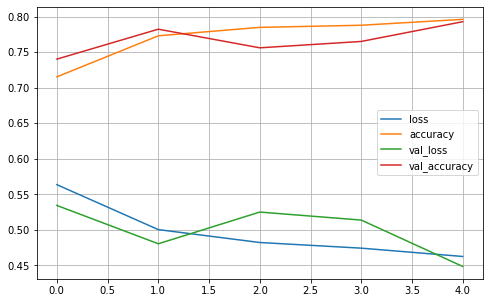

In [57]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [58]:
y_pred = model.predict_classes(x_val, batch_size = 128)

true = 0
for i, y in enumerate(y_val):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Correct Prediction: 3991
Wrong Prediction: 967
Accuracy: 80.49616780960065


In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [60]:
pred_y = model.predict(x_val)

In [65]:
pred_y[:10]

array([[0.16698791],
       [0.9035983 ],
       [0.06081003],
       [0.6706765 ],
       [0.9111984 ],
       [0.7794307 ],
       [0.5860919 ],
       [0.7132289 ],
       [0.07628343],
       [0.08057763]], dtype=float32)

In [63]:
pred = model.predict_classes(x_val)

In [66]:
pred[:10]

array([[0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0]])

In [67]:
cm= confusion_matrix(y_val,y_val)
cm

array([[2459,    0],
       [   0, 2499]], dtype=int64)

In [68]:
cm= confusion_matrix(pred,y_val)
cm

array([[1786,  294],
       [ 673, 2205]], dtype=int64)

In [69]:
test1 = "The movie is fantastic! "
test2 = "bad"

test = [test1,test2]
test_sam = tokenizer_obj.texts_to_sequences(test)
test_sam_pad = pad_sequences(test_sam,maxlen = 50)

a = model.predict_classes(x=test_sam_pad)

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [1]:
# 1= positive, 0 = negative

In [70]:
a

array([[1],
       [0]])

In [72]:
print(classification_report(pred,y_val))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      2080
           1       0.88      0.77      0.82      2878

    accuracy                           0.80      4958
   macro avg       0.80      0.81      0.80      4958
weighted avg       0.82      0.80      0.81      4958

